# Anomalous Differences in Real Space

In the previous examples we used $CC_{anom}$ to validate that there are well-measured anomalous differences in a  sulfur SAD experiment and confirmed that the anomalous difference map showed localized, positive density at each of the sulfur atoms in HEWL. Both of these analyses used reciprocal space measurements to infer something about real space electron density. In this example, we will show how one can directly work in real space by using [NumPy](https://numpy.org/) for both discrete Fourier transforms and representing real-space, voxelized electron density. 

In [1]:
# Plotting
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML, Image
import seaborn as sns
sns.set_context("notebook", font_scale=1.3)

# Analysis
import pandas as pd
import numpy as np
import gemmi

In [2]:
import reciprocalspaceship as rs

In [3]:
print(rs.__version__)

0.9.4


---
### Generate reciprocal grid  

In `reciprocalspaceship` we typically represent reflection data as a 2-dimensional table indexed by Miller indices. This representation is convenient for representing multiple data or metadata fields associated with reflections. However, these Miller indices also correspond to indices into a 3-dimensional, reciprocal space grid. If we format complex structure factors -- structure factor amplitudes and phases -- as the corresponding 3D array, we can directly Fourier transform the data to obtain a real space map. 

The construction of a reciprocal grid from a `DataSet` object is facilitated by the built-in method `DataSet.to_reciprocalgrid()`. Here, we will load the anomalous difference amplitudes and phases, convert them to complex structure factors, and construct the corresponding reciprocal grid. 

In [4]:
anom = rs.read_mtz("data/anomdiff.mtz")

In [5]:
anom["sf_anom"] = anom.to_structurefactor("ANOM", "PHANOM")

In [6]:
reciprocalgrid = anom.to_reciprocalgrid("sf_anom", gridsize=(128, 128, 64))

This reciprocal grid has the low resolution data in the "corners", and is directly compatible with [numpy.fft.fftn()](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftn.html). This can be visualized in a more intuitive manner using the [numpy.fft.fftshift()](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html#numpy.fft.fftshift) function to shift the low resolution structure factors to the center of the array.

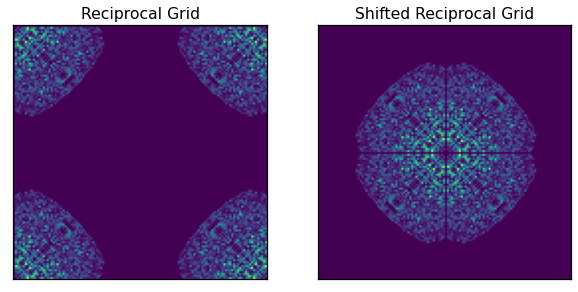

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.abs(reciprocalgrid[:, :, 1]))
axes[0].set_title("Reciprocal Grid")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].imshow(np.abs(np.fft.fftshift(reciprocalgrid[:, :, 1])))
axes[1].set_title("Shifted Reciprocal Grid")
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.show()

From this grid, we can see information about the symmetry of the spacegroup. We can also see that the original data was edge-limited. This is evident from the anisotropy of the populated sections of the grid (rotated square-like appearance)

---
### Compute real space map  

We can now generate our real space map of the anomalous differences. This anomalous difference map contains localized peaks corresponding to the locations of sulfur atoms in the unit cell. 

In [8]:
realmap = np.real(np.fft.fftn(reciprocalgrid))

# Standardize voxel range
realmap = (realmap - realmap.mean())/realmap.std()

To visualize this real space map, we will make a movie corresponding to successive slices of the unit cell density along the c-axis. The contour map at each slice will be on the same scale such that they can be directly compared.

In [9]:
fig = plt.figure(figsize=(6, 6))
camera = Camera(fig)
for i in range(int(realmap.shape[-1])):
    plt.gca().text(0.11, 1.02, f"Anomalous Difference Map (c={i})", 
                   transform=plt.gca().transAxes)
    plt.contour(realmap[:, :, i], levels=10, cmap="gray_r", vmin=3, vmax=15)
    plt.xlabel("b")
    plt.ylabel("a")
    camera.snap()
plt.close()
animation = camera.animate(interval=50, blit=True)
HTML(animation.to_jshtml(fps=10))

In order to inspect a map in a molecular visualization program, it is also possible to write the real-space density to a CCP4 format for representing volumetric data. This can be done using `rs.io.write_ccp4_map()`:

In [10]:
rs.io.write_ccp4_map(realmap, "data/anomdiff.map", anom.cell, anom.spacegroup)

---
### Find Sulfur Sites in Anomalous Difference Map

Using the real-space map of the anomalous differences in each voxel of the unit cell, it is now possible to identify the locations of the sulfur atoms responsible for the anomalous signal. This can be accomplished using peak-finding algorithms, which are available in many image processing libraries. For this example, we will use [peak_local_max()](https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=peak_local_max#skimage.feature.peak_local_max) which is available in [scikit-image](https://scikit-image.org/).

In [11]:
def find_sites(realmap, threshold, cell):
    """
    Find local peaks in map.
    
    Parameters
    ----------
    realmap : np.ndarray
        3D array with voxelized electron density
    threshold : float
        Minimum voxelized density to consider for peaks
    cell : gemmi.UnitCell
        Cell parameters for crystal
        
    Returns
    -------
    pd.DataFrame
        DataFrame with coordinates and peak height for each site
    """
    from skimage import feature
    peaks = feature.peak_local_max(realmap, threshold_abs=threshold, exclude_border=False)
    data = []
    for p in peaks:
        pf = p/np.array(realmap.shape)
        pos = cell.orthogonalize(gemmi.Fractional(*pf))
        d  = {"x": pos.x, "y": pos.y, "z": pos.z}
        d["height"] = realmap[p[0], p[1], p[2]]
        data.append(d)
    return pd.DataFrame(data)

In [12]:
sites = find_sites(realmap, 13.2, anom.cell)

In [13]:
sites

,x,y,z,height
0,0.619874,49.589938,13.587933,20.634899
1,49.589938,0.619874,24.221967,20.634899
2,29.753963,78.724026,5.317017,20.634899
3,78.724026,29.753963,32.492883,20.634899
4,9.917988,39.052076,23.040408,20.634899
...,...,...,...,...
75,17.356478,30.373837,13.587933,13.380321
76,9.298113,57.028428,4.135458,13.380321
77,57.028428,9.298113,33.674442,13.380321
78,22.315472,70.045787,14.769492,13.380321


These 80 sites correspond to the 10 sulfur atoms per HEWL copy and the 8 copies of the protein per unit cell. To visualize these sites, we can write them out to a PDB using the following function:

In [14]:
def write_pdb(sites, cell):
    s = gemmi.Structure()
    s.cell = cell
    m = gemmi.Model("substructure")
    c = gemmi.Chain("A")
    for i, site in sites.iterrows():
        a = gemmi.Atom()
        a.element = gemmi.Element("S")
        a.name = "S"
        a.pos = gemmi.Position(*site[["x", "y", "z"]].values)
        r = gemmi.Residue()
        r.name = "S"
        r.seqid = gemmi.SeqId(str(i+1))
        r.add_atom(a)
        c.append_residues([r])
    m.add_chain(c)
    s.add_model(m)
    s.assign_label_seq_id(force=True)
    s.write_minimal_pdb("data/sites.pdb")
    return

In [15]:
write_pdb(sites, anom.cell)

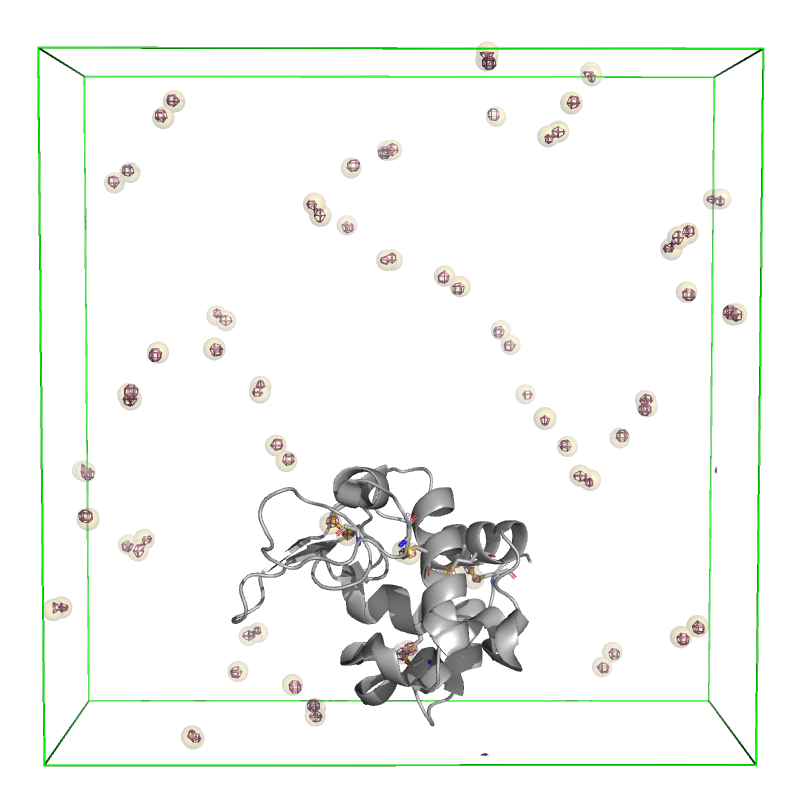

In [16]:
Image("data/sites.png", width=400)

The above image shows the extent of the HEWL unit cell (green) with the anomalous difference map contoured at $10\sigma$ (purple). The 80 sites identified using `find_sites()` are shown as slightly transparent yellow spheres, and an asymmetric unit of HEWL is shown in gray (PDB: 7L84) to emphasize that the sites overlay with the 10 sulfur atoms in the protein. 